In [23]:
#!pip install -U torch torchvision
#!pip install wheel==0.34.1

In [24]:
import torch
import torch.nn.functional as F

import pickle
import numpy as np
from skimage import io
from collections import Counter

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [25]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [26]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

using device: cuda


In [27]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float64')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [28]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [29]:
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [30]:
train_val_files[:3]

[PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('/kaggle/input/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg')]

In [31]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [32]:
val_dataset = SimpsonsDataset(val_files, mode='val')

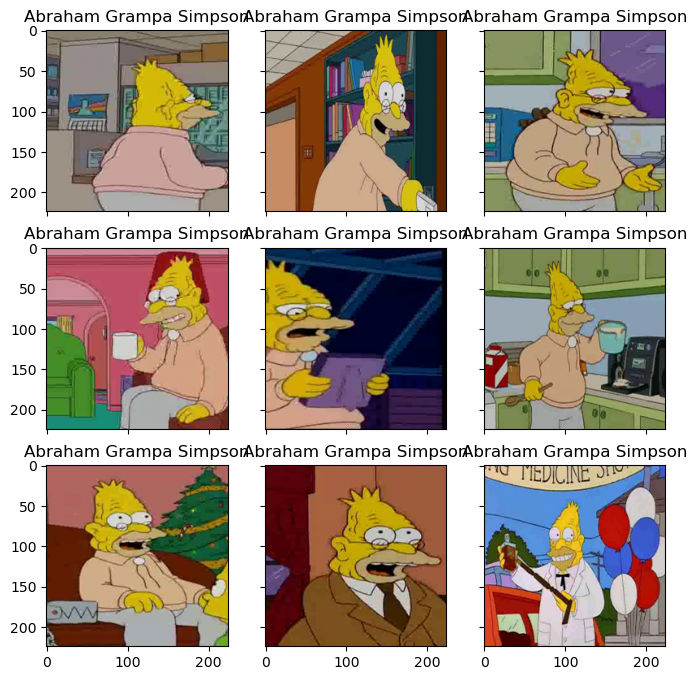

In [33]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,100))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение модели 

In [34]:
n_classes = len(np.unique(train_val_labels))

model = models.efficientnet_b2(weights='DEFAULT')

model.classifier = nn.Sequential(
    nn.Linear(1408, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, n_classes)
)

model.to(DEVICE)
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

### Обучение модели

In [41]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.float().to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.float().to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), amsgrad=True, lr=1e-4)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.83)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            if epoch >= 5:
                s = input("continue [y/n]: ")
                if s.capitalize() != "Y": break

            scheduler.step()

    return history


def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.float().to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [36]:
history = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=32)

epoch:   5%|▌         | 1/20 [03:09<1:00:00, 189.50s/it]


Epoch 001 train_loss: 1.1425     val_loss 0.3586 train_acc 0.7752 val_acc 0.9299


epoch:  10%|█         | 2/20 [06:04<54:19, 181.07s/it]  


Epoch 002 train_loss: 0.1643     val_loss 0.2041 train_acc 0.9592 val_acc 0.9517


epoch:  15%|█▌        | 3/20 [09:00<50:39, 178.79s/it]


Epoch 003 train_loss: 0.0385     val_loss 0.1905 train_acc 0.9898 val_acc 0.9562


epoch:  20%|██        | 4/20 [11:57<47:30, 178.15s/it]


Epoch 004 train_loss: 0.0114     val_loss 0.1702 train_acc 0.9972 val_acc 0.9658


epoch:  25%|██▌       | 5/20 [14:58<44:45, 179.02s/it]


Epoch 005 train_loss: 0.0041     val_loss 0.1629 train_acc 0.9990 val_acc 0.9692


epoch:  30%|███       | 6/20 [18:29<44:19, 189.95s/it]


Epoch 006 train_loss: 0.0013     val_loss 0.1685 train_acc 0.9997 val_acc 0.9702


continue [y/n]:  т


epoch:  30%|███       | 6/20 [19:21<45:09, 193.52s/it]


In [37]:
loss, acc, val_loss, val_acc = zip(*history)

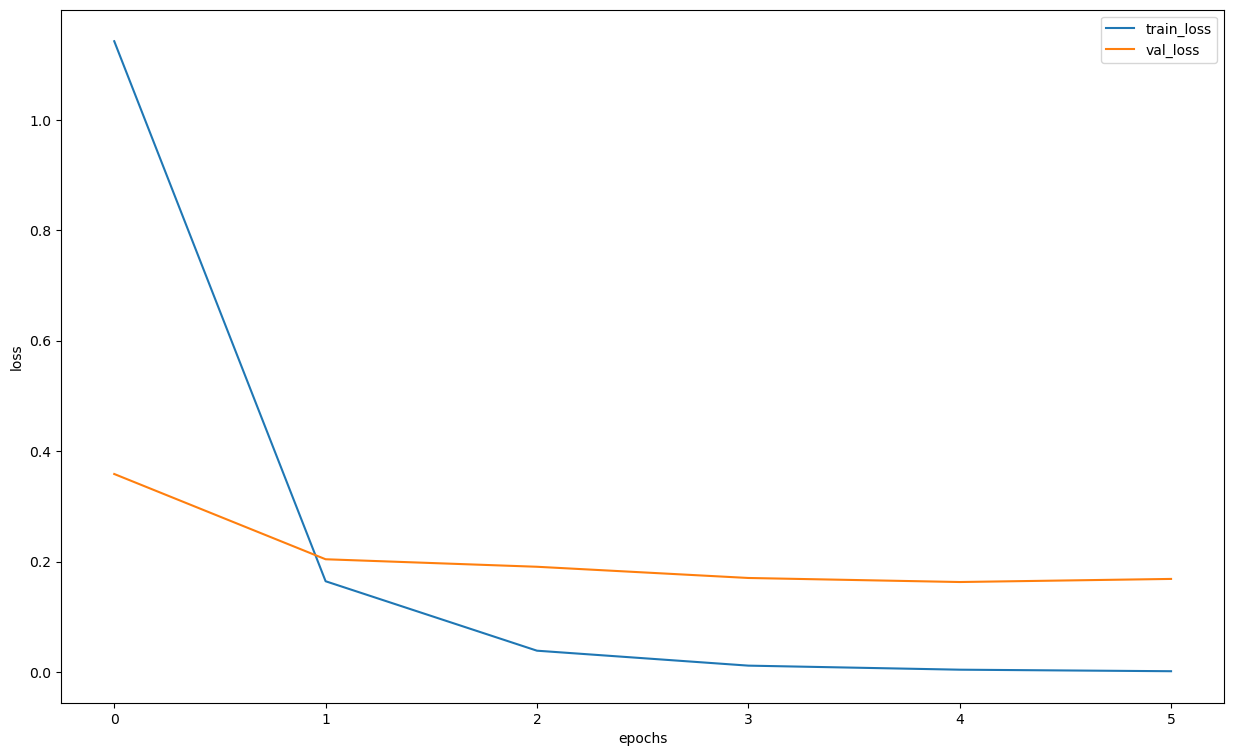

In [39]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Загрузка ответа

In [42]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

label_encoder = pickle.load(open("/kaggle/working/label_encoder.pkl", 'rb'))

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [47]:
f = open("subm.csv", "w")
f.write("Id,Expected\n")

for i, (fil, name) in enumerate(zip(test_filenames, preds)):
    print(i, f"{fil},{name}\n")
    f.write(f"{fil},{name}\n")

0 img0.jpg,nelson_muntz

1 img1.jpg,bart_simpson

2 img10.jpg,ned_flanders

3 img100.jpg,chief_wiggum

4 img101.jpg,apu_nahasapeemapetilon

5 img102.jpg,kent_brockman

6 img103.jpg,edna_krabappel

7 img104.jpg,chief_wiggum

8 img105.jpg,lisa_simpson

9 img106.jpg,kent_brockman

10 img107.jpg,lenny_leonard

11 img108.jpg,marge_simpson

12 img109.jpg,kent_brockman

13 img11.jpg,ned_flanders

14 img110.jpg,moe_szyslak

15 img111.jpg,comic_book_guy

16 img112.jpg,abraham_grampa_simpson

17 img113.jpg,edna_krabappel

18 img114.jpg,kent_brockman

19 img115.jpg,lisa_simpson

20 img116.jpg,marge_simpson

21 img117.jpg,nelson_muntz

22 img118.jpg,comic_book_guy

23 img119.jpg,mayor_quimby

24 img12.jpg,homer_simpson

25 img120.jpg,apu_nahasapeemapetilon

26 img121.jpg,krusty_the_clown

27 img122.jpg,krusty_the_clown

28 img123.jpg,ned_flanders

29 img124.jpg,edna_krabappel

30 img125.jpg,apu_nahasapeemapetilon

31 img126.jpg,chief_wiggum

32 img127.jpg,apu_nahasapeemapetilon

33 img128.jpg,ned_